In [11]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

from data import harmonic_oscillator_solution
from lossfn import mse
from model import FCN

from IPython.display import clear_output

# Train NN to simulate the Harmonic Oscillator system.

In this notebook we attempt to estimate the solution to a Harmonic oscillator system (see the data notebook).

## Inputs
- The data

## Outputs
- Estimation of the solution, eg. $x(t)$

## Approach

The NN model is trained to approximate the solution to the DE, i.e.:

$$
x_{NN}(t,\theta) \approx u(t)~,
$$
Where $\theta$ are the parameters to train.

We will be using a fully connected net

The cost function will just be a simple MSE

In [12]:
def plot_result(x,y,x_data,y_data,yh, title=None):

    plt.figure(figsize=(8,4))
    plt.title(title)
    plt.plot(x,y, color="tab:grey", alpha=0.6, label="Exact solution")
    plt.plot(x,yh, color="tab:green", label="Neural network prediction")
    plt.scatter(x_data, y_data, label='Training data')
    l = plt.legend(loc='best')

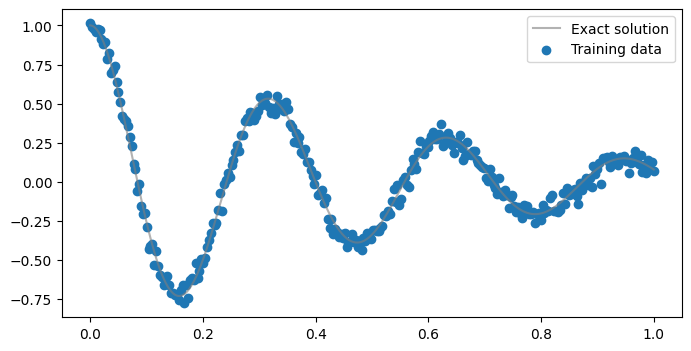

In [13]:
# Full dataset
data = pd.read_csv('./time-oscillation.csv', dtype=np.float32)

d, w0 = 2, 20
t_true = torch.linspace(0,1,500).view(-1,1)
obs_true = harmonic_oscillator_solution(d, w0, t_true)

t_data = torch.tensor(data['t'].values).view(-1,1)
obs_data = torch.tensor(data['observation'].values).view(-1,1)

plt.figure(figsize=(8,4))
plt.plot(t_true, obs_true, color="tab:grey", alpha=0.6, label="Exact solution")
plt.scatter(t_data, obs_data, label="Training data")
plt.legend()
plt.show()

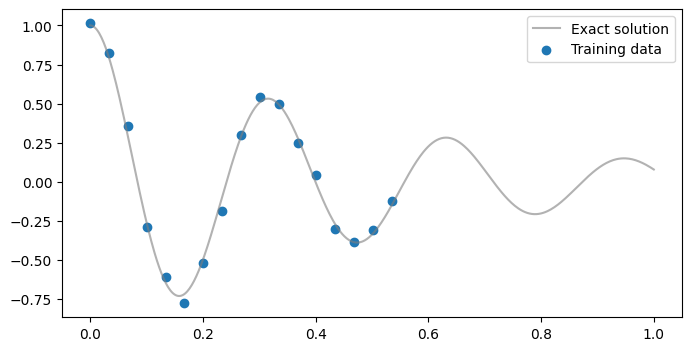

In [14]:
total = 100
percentage = 55

d, w0 = 2, 20
t_true = torch.linspace(0,1,500).view(-1,1)[:int(np.ceil(total/100*500))]
obs_true = harmonic_oscillator_solution(d, w0, t_true)

t_data = torch.tensor(data['t'].values)[:int(np.ceil(percentage/100*len(data)))][::10].view(-1,1)
obs_data = torch.tensor(data['observation'].values)[:int(np.ceil(percentage/100*len(data)))][::10].view(-1,1)

plt.figure(figsize=(8,4))
plt.plot(t_true, obs_true, color="tab:grey", alpha=0.6, label="Exact solution")
plt.scatter(t_data, obs_data, label="Training data")
plt.legend()
plt.show()

In [15]:
# torch.manual_seed(123)
model = FCN(N_INPUT=1, N_OUTPUT=1, N_HIDDEN=9, N_LAYERS=3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
all_loss =[]

In [16]:
sum(p.numel() for p in model.parameters())

208

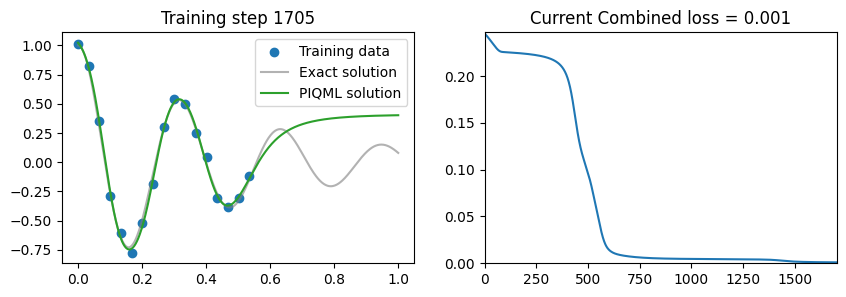


        - MSE: 0.0009998781606554985
        
[0.24674774706363678, 0.24591563642024994, 0.24524396657943726, 0.2447216659784317, 0.24432766437530518, 0.24403005838394165, 0.24379399418830872, 0.24358651041984558, 0.2433808296918869, 0.24315917491912842, 0.24291378259658813, 0.24264495074748993, 0.24235814809799194, 0.2420613318681717, 0.24176263809204102, 0.24146899580955505, 0.2411850243806839, 0.240912526845932, 0.24065068364143372, 0.24039658904075623, 0.24014610052108765, 0.239894837141037, 0.23963911831378937, 0.23937654495239258, 0.23910637199878693, 0.23882927000522614, 0.23854704201221466, 0.23826183378696442, 0.23797594010829926, 0.23769080638885498, 0.23740729689598083, 0.23712508380413055, 0.23684336245059967, 0.23656076192855835, 0.23627617955207825, 0.23598875105381012, 0.23569834232330322, 0.23540525138378143, 0.23511043190956116, 0.23481494188308716, 0.23451967537403107, 0.23422525823116302, 0.23393186926841736, 0.23363934457302094, 0.23334722220897675, 0.2330551296472

In [17]:
for i in range(15001):
    optimizer.zero_grad()

    prediction = model(t_data)
    loss = mse (prediction, obs_data) # use mean squared error
    loss.backward()
    
    optimizer.step()
    all_loss.append(loss.item())

    if i % 1 == 0: 
        clear_output(wait=True)
        prediction = model(t_true).detach()
        # plt.figure(figsize=(8,2.5))

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3))
        ax1.scatter(t_data.detach(), obs_data.detach(), label="Training data")
        ax1.plot(t_true.detach()[:,0], obs_true.detach()[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        ax1.plot(t_true.detach()[:,0], prediction.detach()[:,0], label="PIQML solution", color="tab:green")
        ax1.legend()
        ax1.set_title(f"Training step {i+1}")

        ax2.plot(all_loss)
        ax2.set_xlim(0, len(all_loss))
        ax2.set_ylim(0, all_loss[0])
        
        ax2.set_title(f"Current Combined loss = {np.around(loss.item(), 4)}")
        plt.savefig(f'./plots/NN_simple/i_{i}.png', dpi=300)
        plt.show()
        
        print(f'''
        - MSE: {loss}
        ''')

        print(all_loss)
        # print(list(model.parameters())) # Uncomment this to see parameters updating
    if loss <= 0.001: break



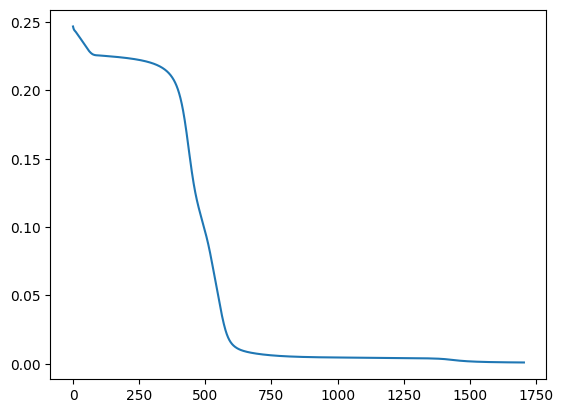

In [18]:
plt.plot(all_loss)

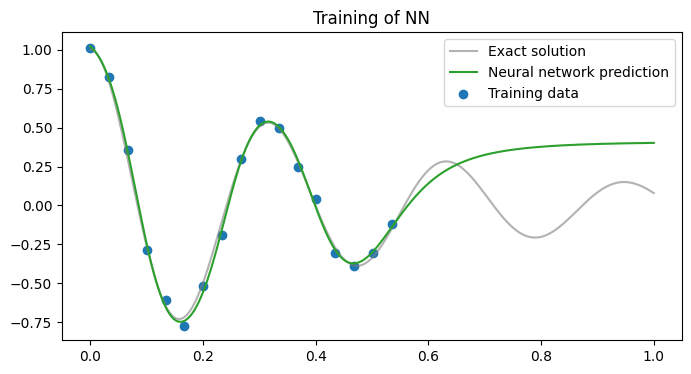

In [19]:
yh = model(t_true).detach()

mse_nn = mse(obs_true, yh)
plot_result(t_true,obs_true,t_data,obs_data,yh, title=f'Training of NN')

In [20]:
np.mean((harmonic_oscillator_solution(d=2, w0=20, t=t_true) - model(t_true)).detach().numpy())**2

0.014440667070642954